In [57]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [58]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

hidden_layer_size = 256

lr = 0.001

In [59]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        activation_1 = F.relu(self.fc1(x))
        x = self.fc2(activation_1)
        return x, activation_1
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (fc1): Linear (3072 -> 256)
  (fc2): Linear (256 -> 10)
)


In [60]:
class ActivationFollower():
    
    train_activations = 0
    test_activations = 0
    
    def __init__(self):
        self.train_activations = 0
        self.test_activations = 0
    
    def reset(self):
        train_activations = 0
        test_activations = 0
    
    def train_add(self, x):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
        else:
            self.train_activations = x
    
    def test_add(self, x):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
        else:
            self.test_activations = x
        
    def print_metrics(self):
        # plt.figure(figsize=(20,10))
        bins = np.arange(0, 1.1, 0.1)
        plt.title('Histogram of probability to activate')
        plt.hist(np.where(self.train_activations == 0., 1, 0).mean(0), bins=bins)
        plt.show()
        # bins = np.logspace(-8, 2, 11)
#         for i in range(self.train_activations.shape[1]):
#             plt.hist(self.train_activations.transpose()[i], log=True, bins=bins)
#         plt.title('Histogram of activation values')
#         plt.gca().set_xscale("log")
#         # plt.xlim(0.01, 20)
#         plt.show()
        

In [61]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [62]:
if cuda:
    model.cuda()
    criterion.cuda()

In [63]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations.cpu().data.numpy())
    for batch_idx, (data, target) in enumerate(testloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.test_add(activations.cpu().data.numpy())
        
    metrics.print_metrics()
    return metrics

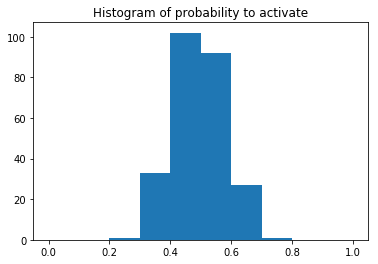

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.319208
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.739658
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.035817
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.581518
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.896078
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.798705
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.586294
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.749000

Test set: Average loss: 1.5524, Accuracy: 4594/10000 (46%)



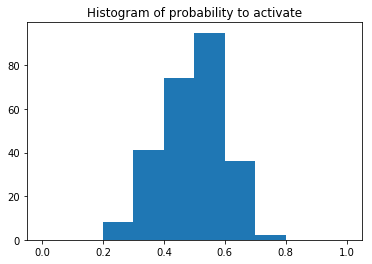

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.654669
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.114783
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.593638
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.384373
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.386416
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.466991
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.411929
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.974365

Test set: Average loss: 1.4691, Accuracy: 4827/10000 (48%)



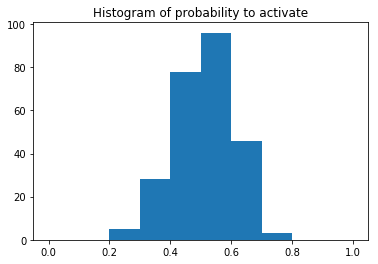

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.024812
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.075489
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.629746
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.671036
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.063111
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.569262
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.549116
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.247687

Test set: Average loss: 1.4089, Accuracy: 5052/10000 (51%)



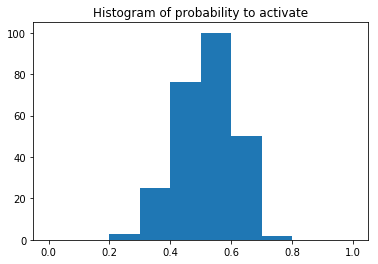

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.599207
Train Epoch: 4 [6400/50000 (13%)]	Loss: 1.663639
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.446122
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.382615
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.813774
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.390971
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.458048
Train Epoch: 4 [44800/50000 (90%)]	Loss: 1.297495

Test set: Average loss: 1.3708, Accuracy: 5176/10000 (52%)



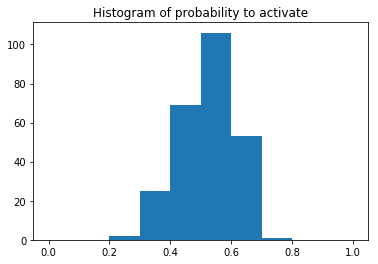

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.455943
Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.412000
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.008031
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.144863
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.052766
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.360118
Train Epoch: 5 [38400/50000 (77%)]	Loss: 0.884104
Train Epoch: 5 [44800/50000 (90%)]	Loss: 0.984612

Test set: Average loss: 1.3678, Accuracy: 5230/10000 (52%)



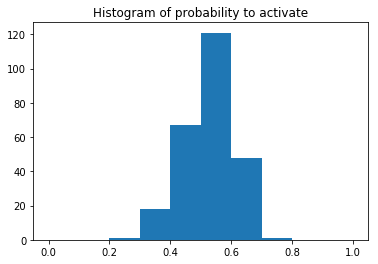

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.935213
Train Epoch: 6 [6400/50000 (13%)]	Loss: 1.143615
Train Epoch: 6 [12800/50000 (26%)]	Loss: 1.940460
Train Epoch: 6 [19200/50000 (38%)]	Loss: 1.227892
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.305275
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.006347
Train Epoch: 6 [38400/50000 (77%)]	Loss: 1.314831
Train Epoch: 6 [44800/50000 (90%)]	Loss: 1.169417

Test set: Average loss: 1.3760, Accuracy: 5178/10000 (52%)



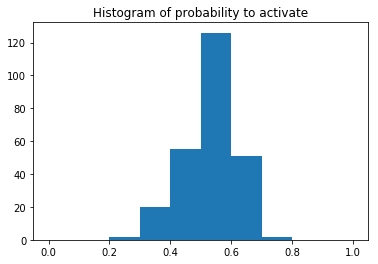

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.457925
Train Epoch: 7 [6400/50000 (13%)]	Loss: 1.454913
Train Epoch: 7 [12800/50000 (26%)]	Loss: 1.225981
Train Epoch: 7 [19200/50000 (38%)]	Loss: 1.318684
Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.936444
Train Epoch: 7 [32000/50000 (64%)]	Loss: 0.819238


Process Process-400:
Process Process-399:
Traceback (most recent call last):
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
    self.run()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
    r = index_queue.get()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/queues.py", line 378, in get
    samples = collate_fn([dataset[i] for i in

KeyboardInterrupt: 

  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torchvision-0.1.8-py2.7.egg/torchvision/datasets/cifar.py", line 96, in __getitem__
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    img = Image.fromarray(img)
    buf = self.recv_bytes()
    Note that this function decodes pixel data only, not entire images.
KeyboardInterrupt
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/PIL/Image.py", line 2144, in frombuffer


In [64]:
activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    activation_metrics()